In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data = pd.read_csv('./Data/H1B_2017.csv', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622773 entries, 0 to 622772
Data columns (total 13 columns):
Unnamed: 0              622773 non-null int64
employer                622773 non-null object
job_title               622773 non-null object
occupational_name       622773 non-null object
prevailing_wage         622773 non-null float64
pw_wage_period          622773 non-null object
employer_wage           622773 non-null float64
employer_max_wage       622773 non-null float64
employer_wage_period    622773 non-null object
city                    622773 non-null object
county                  622773 non-null object
state                   622773 non-null object
postal_code             622773 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 61.8+ MB


In [4]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,employer,job_title,occupational_name,prevailing_wage,pw_wage_period,employer_wage,employer_max_wage,employer_wage_period,city,county,state,postal_code
0,DISCOVER PRODUCTS INC.,ASSOCIATE DATA INTEGRATION,COMPUTER SYSTEMS ANALYSTS,59197.0,Year,65811.0,67320.0,Year,RIVERWOODS,LAKE,IL,60015
1,DFS SERVICES LLC,SENIOR ASSOCIATE,OPERATIONS RESEARCH ANALYSTS,49800.0,Year,53000.0,57200.0,Year,RIVERWOODS,LAKE,IL,60015
2,INFO SERVICES LLC,PROJECT MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER",90376.0,Year,102000.0,0.0,Year,JERSEY CITY,HUDSON,NJ,07302
3,BB&T CORPORATION,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,CREDIT ANALYSTS,116605.0,Year,132500.0,0.0,Year,NEW YORK,NEW YORK,NY,10036
4,"SUNTRUST BANKS, INC.",CREDIT RISK METRICS SPECIALIST,"FINANCIAL SPECIALISTS, ALL OTHER",59405.0,Year,71750.0,0.0,Year,ATLANTA,FULTON,GA,30303


In [5]:
data.describe()

,prevailing_wage,employer_wage,employer_max_wage
count,6.227730e+05,6.227730e+05,6.227730e+05
mean,9.971660e+04,1.047551e+05,2.412360e+04
std,1.811748e+06,1.809885e+06,5.253267e+04
min,1.508000e+04,1.500000e+04,0.000000e+00
25%,5.953000e+04,6.500000e+04,0.000000e+00
50%,7.178100e+04,7.785000e+04,0.000000e+00
75%,9.035500e+04,1.000000e+05,0.000000e+00
max,4.013610e+08,3.120000e+08,3.000000e+06


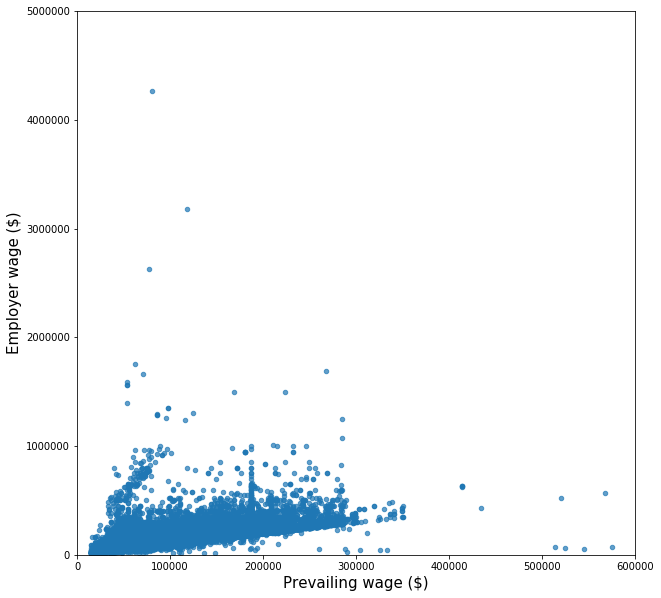

Pearson correlation considering all the data points: 0.0748


In [6]:
plt.figure(figsize=(10,10))
plt.scatter(data.prevailing_wage, data.employer_wage, alpha=0.7, s=20)
plt.xlabel('Prevailing wage ($)', size=15)
plt.xlim(0,600000)
plt.ylabel('Employer wage ($)', size=15)
plt.ylim(0,5000000)
plt.title('')
plt.show()

pearson = np.corrcoef(data.prevailing_wage, data.employer_wage)[0,1]
print("Pearson correlation considering all the data points: %.4f" %pearson)

From the plot above we realize that there is a considerable amount of points, at the top right and botto left, falling outside the common range of values for the prevailing wage and the employer's wage. These points are a potential source of error for the model, so the best option before start developing a model is to remove outliers. using.

# Defining and removing outliers

[Tukey's method](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/) consists on determining the inter-quartile range (IQR) and remove points having values below the first quartile (Q1) minus 1.5 x IQR and points over the third quartile (Q3) plus 1.5 x IQR.  

In [7]:
# Q1 and Q3 of prevailing wage
pr_Q1, pr_Q3 = np.percentile(data.prevailing_wage, [25, 75])
pr_IQR = pr_Q3 - pr_Q1
# Q1 and Q3 of employer wage
em_Q1, em_Q3 = np.percentile(data.employer_wage, [25, 75])
em_IQR = em_Q3 - em_Q1
# Min and Max value for prevailing wage
pr_min = pr_Q1 - 1.5 * pr_IQR
pr_max = pr_Q3 + 1.5 * pr_IQR
# Min and Max value for employer wage
em_min = em_Q1 - 1.5 * em_IQR
em_max = em_Q3 + 1.5 * em_IQR
# Filters to eliminate outliers
pr_filter = (data.prevailing_wage > pr_min) & (data.prevailing_wage < pr_max)
em_filter = (data.employer_wage > em_min) & (data.employer_wage < em_max)

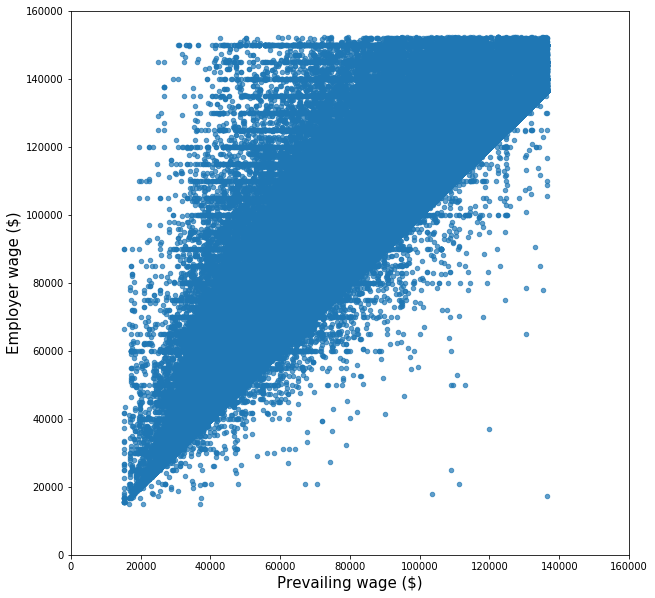

Pearson correlation without outliers per Tukey's criteria: 0.8725


In [8]:
plt.figure(figsize=(10,10))
plt.scatter(data.prevailing_wage[pr_filter & em_filter], \
            data.employer_wage[pr_filter & em_filter], alpha=0.7, s=20)
plt.xlabel('Prevailing wage ($)', size=15)
plt.xlim(0,160000)
plt.ylabel('Employer wage ($)', size=15)
plt.ylim(0,160000)
plt.title('')
plt.show()

new_pearson = np.corrcoef(data.prevailing_wage[pr_filter & em_filter], \
                      data.employer_wage[pr_filter & em_filter])[0,1]
print("Pearson correlation without outliers per Tukey's criteria: %.4f" %new_pearson)

Let's define an arbitrary resonable criteria of a maximum of $300K for the salaries to compare with Tukey's criteria.

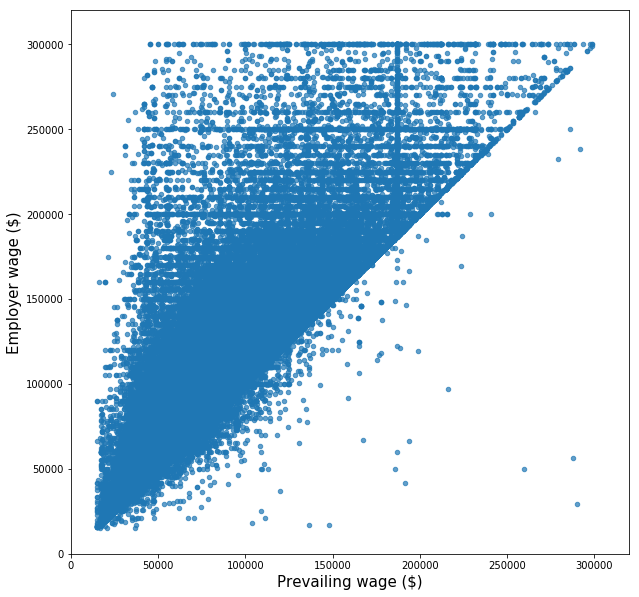

Pearson correlation considering points below $300K: 0.8633


In [9]:
# Filter of $300K for prevailing and employer wage
filter1 = (data.prevailing_wage<=300000) & (data.employer_wage<=300000)

plt.figure(figsize=(10,10))
plt.scatter(data.prevailing_wage[filter1], \
            data.employer_wage[filter1], alpha=0.7, s=20)
plt.xlabel('Prevailing wage ($)', size=15)
plt.xlim(0,320000)
plt.ylabel('Employer wage ($)', size=15)
plt.ylim(0,320000)
plt.title('')
plt.show()

new_pearson = np.corrcoef(data.prevailing_wage[filter1], \
                      data.employer_wage[filter1])[0,1]
print("Pearson correlation considering points below $300K: %.4f" %new_pearson)

If we define the data to develop the model without the outliers per the Tukey's criteria we obtain: 

In [10]:
# Selecting possible features to train model
columns = ['job_title', 'occupational_name', 'prevailing_wage', 'city', 'county', 'state', 'postal_code']
features = data[columns]
# Selecting data
X = features[pr_filter & em_filter].reset_index(drop=True)
# Selecting target
y = data.employer_wage[pr_filter & em_filter].reset_index(drop=True)
# Print number of possible values per feature target
print("Using Tukey's criteria:")
for col in columns:
    print("\t Number of unique values for column -{}- : {}".format(col, len(X[col].unique())))
print("\t Number of unique values for column -employer_wage- : {}".format(len(y.unique())))

Using Tukey's criteria:
	 Number of unique values for column -job_title- : 84724
	 Number of unique values for column -occupational_name- : 849
	 Number of unique values for column -prevailing_wage- : 19900
	 Number of unique values for column -city- : 7652
	 Number of unique values for column -county- : 3550
	 Number of unique values for column -state- : 57
	 Number of unique values for column -postal_code- : 12177
	 Number of unique values for column -employer_wage- : 44632


If we define the data to develop the model without the outliers per the $300K criteria we obtain: 

In [11]:
# Selecting data
X = features[filter1].reset_index(drop=True)
# Selecting target
y = data.employer_wage[filter1].reset_index(drop=True)
# Print number of possible values per feature target
print('Using the $300K:')
for col in columns:
    print("\t Number of unique values for column -{}- : {}".format(col, len(X[col].unique())))
print("\t Number of unique values for column -employer_wage- : {}".format(len(y.unique())))

Using the $300K:
	 Number of unique values for column -job_title- : 92349
	 Number of unique values for column -occupational_name- : 865
	 Number of unique values for column -prevailing_wage- : 23636
	 Number of unique values for column -city- : 7915
	 Number of unique values for column -county- : 3652
	 Number of unique values for column -state- : 57
	 Number of unique values for column -postal_code- : 12609
	 Number of unique values for column -employer_wage- : 50125


In [12]:
print("Number of points for the whole data set: {}".format(len(data)))
print("Number of points for salaries with Tukey's criteria: {}".format(len(data[pr_filter & em_filter])))
print("Number of points for salaries with the $300K criteria: {}".format(len(data[filter1])))

Number of points for the whole data set: 622773
Number of points for salaries with Tukey's criteria: 588762
Number of points for salaries with the $300K criteria: 620729


Eliminating outliers using Tukey's criteria results in a slightly better correlation between the prevailing wage and the employer wage compared to the \$300K criteria, 0.8725 against 0.8633. However Tukey's criteria diminishes considerably the number of possible values per category compared to the \$300K criteria and eliminates 5.46% of the original data while the $300K criteria only eliminates 0.33% of the data points. For this reason, the best option to develop the model is using the \$300K criteria.


In [13]:
# Selecting possible features to train model
columns = ['job_title', 'occupational_name', 'prevailing_wage', 'city', 'county', 'state', 'postal_code']
features = data[columns]
# Selecting data
X = features[pr_filter & em_filter].reset_index(drop=True)
# Selecting target
y = data.employer_wage[pr_filter & em_filter].reset_index(drop=True)

-------------------------------

# Defining testing and validation sets

Let's define the training and validation set as well as a seed for the random operations in order to preserve reproducibility:

In [14]:
# Definition of random parameters
seed = 14
np.random.seed(seed)

In [326]:
from sklearn.model_selection import train_test_split

# Creating testing and training sets
X_train, X_val, y_train, y_val = \
                    train_test_split(X, y, test_size=0.20, random_state=seed)

-------------------------------------

-------------------------------------

# Splitting training data

Let's remember that the purpose of this project is to predict employer's wage. The data contains prevailing wage but it is a fair assumption to consider that most probably a person trying to define her wage is not aware of the prevailing wage given that this one is defined by the US Department of Labor in a case by case base.

It was shown above that prevaling wage and employer wage are highly correlated, indicating that a variance in prevailing wage causes a strong variance in employer wage. Then it appears as a good choice to use prevailing wage as one predictor fro employer wage.

Given that in most cases prevailing wage will be unknown by a user of the model, the first step is to predict prevailing wage and then use the predicted prevailing wage to determine employer wage. For this reason, the training sets are divided in two:
- A set to predict in a first step prevailing wage;
- And a set finally develop the model to predict employer wage.

In [16]:
# Lenght of new sets
len_train = int(len(X_train)/2)
# Set to predict prevailing wage
pr_X = X_train[:len_train]
pr_y_ = y_train[:len_train]
# Set to predict employer wage
em_X = X_train[len_train:]
em_y = y_train[len_train:]

-------------------------------

# Model 1: Predict prevailing wage

For this model, that we call model 1, we don't need the employer wage so we redefine the first set defined above and we split it set into a training and test set. In this case the target is the prevailing wage that is contained in pr_X and the target is the natural logarithm the prevailing wage. After redefining the set we again split it between train and test set for model 1.

In [17]:
# Target
pr_y_log = np.log(pr_X.prevailing_wage)
# Features
pr_X = pr_X.drop(['prevailing_wage'], axis=1)

In [18]:
# Train and test sets
pr_X_train, pr_X_test, pr_y_train, pr_y_test = \
                    train_test_split(pr_X, pr_y_log, test_size=0.20, random_state=seed)

### Model 1 - Method 1: encode text from categorical columns in sparse vectors

The features avalaible to predict prevailing wage are categorical, then we treat them as words. The first approach is to merge per column the features by preserving the space between words and creating a TF-IDF vectorizer describing the new merged features. 

We also create a benchmark model, in this case a linear regression, to be able to compare the model later. 

In [19]:
# Merging columns per row
pr_X_train['merged'] = pr_X.job_title + " " + pr_X.occupational_name + " " + pr_X.city \
                    + " " + pr_X.county + " " + pr_X.state + " " + pr_X.postal_code

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Benchmark model: standard linear regression

We do first a cross validation grid search on the TF-IDF vectorizer to check if it is worth to coonsider an n-gram model.

In [20]:
from sklearn.model_selection import KFold
# Defining cross validation object
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time

# Define pipeline and steps
steps = [('vect', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('linr', LinearRegression())]
pipeline = Pipeline(steps)
# Parameters for grid search
parameters = {'vect__ngram_range': [(1, 1), (1,2), (1,3)]}
# Define grid search
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring='neg_mean_absolute_error')
# Train
start = time()
grid_search.fit(pr_X_train.merged, pr_y_train)
end = time()

print("Grid-search time: %.3f" %(end-start))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Grid-search time: 2465.953
Best score: -0.146
Best parameters set:
	vect__ngram_range: (1, 1)


From the grid search the best n-gram is (1,1), meaning that using an n-gram vectorizer doesn't improve the model. Knowing this, the model is now trained in the full test data set.

In [22]:
# Define pipeline and steps
steps = [('vectorizer', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('regressor', LinearRegression())]
benchmark_pipeline = Pipeline(steps)
# Train
start = time()
benchmark_pipeline.fit(pr_X_train.merged, pr_y_train)
end = time()
print("Linear Regressor training time: %.3fs" %(end-start))

Linear Regressor training time: 24.987s


In [23]:
from sklearn.metrics import mean_absolute_error

# Test data to merged form
pr_X_test['merged'] = pr_X.job_title + " " + pr_X.occupational_name + " " + pr_X.city \
                    + " " + pr_X.county + " " + pr_X.state + " " + pr_X.postal_code
# Prediction by the model
pr_X_test_pred = benchmark_pipeline.predict(pr_X_test.merged)
# Error on natural log data
benchmark_error = mean_absolute_error(pr_y_test, pr_X_test_pred)
print("Benchmark model - LinearRegressor:")
print("\t Mean absolute error in natural log values: %.3f" %benchmark_error)
# Error on real data
pr_X_test_pred_real = np.exp(pr_X_test_pred)
pr_y_test_real = np.exp(pr_y_test)
benchmark_error_real = mean_absolute_error(pr_y_test_real, pr_X_test_pred_real)
print("\t Mean absolute error in dollars: $%.3f" %benchmark_error_real)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Benchmark model - LinearRegressor:
	 Mean absolute error in natural log values: 0.145
	 Mean absolute error in dollars: $10580.366


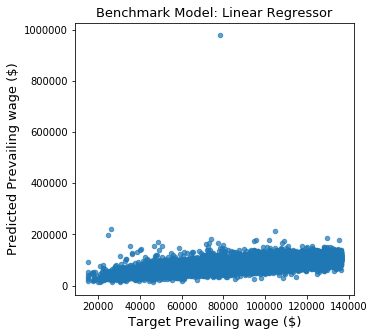

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(pr_y_test_real, pr_X_test_pred_real, alpha=0.7, s=20)
plt.xlabel('Target Prevailing wage ($)', size=13)
plt.ylabel('Predicted Prevailing wage ($)', size=13)
plt.title('Benchmark Model: Linear Regressor', size=13)
plt.show()

The benchmark model has an absolut error of less than $10,600. Now the purpose is to create a model lowering that error.

#### Improving over benchmark model

The plot above showing several points with a predicted prevailing wage higher than the target, suggests that the outliers in the data, which were not totally removed given that we chose as a criteria salaries less than $300K, played a role when fitting the model. To deal appropriately with those outliers a [Hubert regressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) is proposed.

**a. Huber regressor:**

In [25]:
from sklearn.linear_model import HuberRegressor

# Define pipeline
steps1 = [('vect1', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('hubr', HuberRegressor(max_iter=600))]
pipeline1 = Pipeline(steps1)
# Grid search parameters
parameters = {'hubr__epsilon': [1, 1.05, 1.15, 1.25],
              'hubr__alpha': [0, 0.1, 0.01]}
#Grid search
grid_search = GridSearchCV(pipeline1, param_grid=parameters, cv=cv, scoring='neg_mean_absolute_error')

start = time()
grid_search.fit(pr_X_train.merged, pr_y_train)
end = time()

print("Grid-search time: %.3f" %(end-start))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Grid-search time: 1513.005
Best score: -0.142
Best parameters set:
	hubr__alpha: 0.1
	hubr__epsilon: 1


Having determined the best optimal parameters for the Hubert regressor, now we proceed to use all the training data to fit the Hubert regressor model for prevailing wage prediction.

In [26]:
# Define pipeline
steps1 = [('vect1', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('hubr', HuberRegressor(alpha=0.1, epsilon=1, max_iter=700))]
pipeline1 = Pipeline(steps1)
# Train
start = time()
pipeline1.fit(pr_X_train.merged, pr_y_train)
end = time()
print("Huber Regressor training time: %.3fs" %(end-start))

Huber Regressor training time: 32.812s


In [27]:
# Prediction by the model
pr_pred1 = pipeline1.predict(pr_X_test.merged)
# Error on natural log data
pipeline1_error = mean_absolute_error(pr_y_test, pr_pred1)
print("Benchmark model - LinearRegressor:")
print("\t Mean absolute error in natural log values: %.3f" %pipeline1_error)
# Error on real data
pr_pred1_real = np.exp(pr_pred1)
pipeline1_error_real = mean_absolute_error(pr_y_test_real, pr_pred1_real)
print("\t Mean absolute error in dollars: $%.3f" %pipeline1_error_real)

Benchmark model - LinearRegressor:
	 Mean absolute error in natural log values: 0.141
	 Mean absolute error in dollars: $10237.536


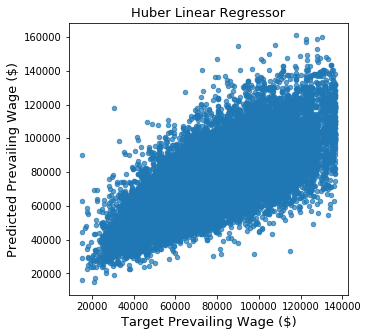

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(pr_y_test_real, pr_pred1_real, alpha=0.7, s=20)
plt.xlabel('Target Prevailing Wage ($)', size=13)
plt.ylabel('Predicted Prevailing Wage ($)', size=13)
plt.title('Huber Linear Regressor', size=13)
plt.show()

The Hubert regressor, which is well suited when dealing with, outliers slightly outperforms the linear regressor resulting in an average mean absolute error of $10,237.536.

Keeping this in mind, in the search for the most appropriate model, given that all the features are categorical, let's try a random forest regressor that avoids merging all the features into one column as we did previously.

**b. Random forest:**

The use of random forest or any other three regression algorithm from scikit-learn requires numerical labels. To do this, it is enough to count the number of different labels in a category and assign a number to each label. However this numerical encoding can be translated into giving more importance to labels with higher assigned number which can introduce a bias to the algortihm. To deal with this issue, the most common labels in a category are assigned higher levels.

First we create a dictionary where the keys are the features or variables and the values contain the respective numerical mapping.

In [188]:
# Dictionary containing mapping codes for each feature
coding_dic1 = {}
for column in pr_X.columns:
    # Counting values 
    map_counts = pr_X_train[column].value_counts()
    # Assign maximum value to most common label
    coding_dic1[column] = dict(zip(map_counts.index, np.arange(map_counts.shape[0] - 1, -1, -1)))

In [189]:
# Function adding encoded columns to data set
def encode_feats(df, coding_dic):
    feats_encoded = []
    for feat in coding_dic.keys():
        feat_dict = coding_dic[feat]
        df[feat+'_enc'] = df[feat].map(feat_dict)
        feats_encoded.append(feat+'_enc')
    return feats_encoded

We add the encoded columns to the data frame for each categorical feature.

In [190]:
# Apply encode_feats to training data
feats_enc = encode_feats(pr_X_train, coding_dic1)
pr_X_train.head()

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_title,occupational_name,city,county,state,postal_code,merged,job_title_enc,occupational_name_enc,city_enc,county_enc,state_enc,postal_code_enc
130885,ASSISTANT PROFESSOR,"POLITICAL SCIENCE TEACHERS, POSTSECONDARY",FORT WORTH,TARRANT,TX,76129,ASSISTANT PROFESSOR POLITICAL SCIENCE TEACHERS...,37029,473,5012,2264,54,4140
462144,COMPUTER PROGRAMMER,COMPUTER PROGRAMMERS,AURORA,DUPAGE,IL,60504,COMPUTER PROGRAMMER COMPUTER PROGRAMMERS AUROR...,37034,640,4926,2263,51,8631
531234,BUSINESS INFORMATION DEVELOPER SENIOR,"COMPUTER OCCUPATIONS, ALL OTHER",NORFOLK,NORFOLK CITY,VA,23502,BUSINESS INFORMATION DEVELOPER SENIOR COMPUTER...,12799,639,4920,2167,44,8677
138086,PROGRAMMER ANALYST,COMPUTER SYSTEMS ANALYSTS,BOSTON,SUFFOLK,MA,02111,PROGRAMMER ANALYST COMPUTER SYSTEMS ANALYSTS B...,37039,641,5061,2295,50,8761
76254,SYSTEMS DEVELOPMENT SPECIALIST,"SOFTWARE DEVELOPERS, APPLICATIONS",LEWISVILLE,DENTON,TX,75067,SYSTEMS DEVELOPMENT SPECIALIST SOFTWARE DEVELO...,35610,642,4847,2235,54,8412


Only the columns containing the encoding information are used to train the random forest regressor.

In [191]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=20)
start = time()
forest.fit(pr_X_train[feats_enc], pr_y_train)
end = time()

print("Random Forest training time: %.3fs" %(end-start))

Random Forest training time: 16.466s


In [192]:
# Apply encode_feats to test data
feats_enc = encode_feats(pr_X_test, coding_dic1)
pr_X_test.fillna(-1, inplace=True)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [193]:
# Prediction by the model
pr_pred_forest = forest.predict(pr_X_test[feats_enc])
# Error on natural log data
forest_error = mean_absolute_error(pr_y_test, pr_pred_forest)
print("Random Forest:")
print("\t Mean absolute error in natural log values: %.3f" %forest_error)
# Error on real data
pr_pred_forest_real = np.exp(pr_pred_forest)
forest_error_real = mean_absolute_error(pr_y_test_real, pr_pred_forest_real)
print("\t Mean absolute error in dollars: $%.3f" %forest_error_real)

Random Forest:
	 Mean absolute error in natural log values: 0.128
	 Mean absolute error in dollars: $9346.882


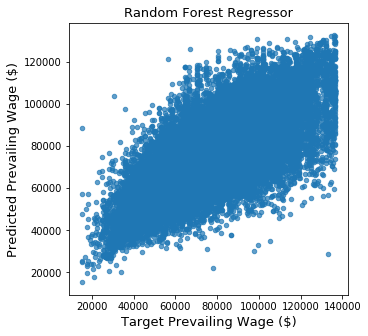

In [194]:
plt.figure(figsize=(5,5))
plt.scatter(pr_y_test_real, pr_pred_forest_real, alpha=0.7, s=20)
plt.xlabel('Target Prevailing Wage ($)', size=13)
plt.ylabel('Predicted Prevailing Wage ($)', size=13)
plt.title('Random Forest Regressor', size=13)
plt.show()

**c. Analysis and conclusion:**

In [195]:
print("Test data prevailing wage mean and standard deviaton: $%.3f ± $%.3f" \
      %(np.mean(pr_y_test_real), np.std(pr_y_test_real)))
print("\t  Huber regressor mean and standard deviaton: $%.3f ± $%.3f" \
      %(np.mean(pr_pred1_real), np.std(pr_pred1_real)))
print("\t  Random forest mean and standard deviaton: $%.3f ± $%.3f" \
          %(np.mean(pr_pred_forest_real), np.std(pr_pred_forest_real)))
print("\n   Pearson correlation between predictions and targets:")
print("\t   Huber regressor Pearson correlation: %.3f" \
      %np.corrcoef(pr_y_test_real, pr_pred1_real)[0,1])
print("\t   Random forest Pearson correlation: %.3f" \
      %np.corrcoef(pr_y_test_real, pr_pred_forest_real)[0,1])

Test data prevailing wage mean and standard deviaton: $73514.857 ± $21143.403
	  Huber regressor mean and standard deviaton: $72483.050 ± $17519.273
	  Random forest mean and standard deviaton: $72631.928 ± $16934.066

   Pearson correlation between predictions and targets:
	   Huber regressor Pearson correlation: 0.760
	   Random forest Pearson correlation: 0.771


From the errors found previously, \$10,237.536 and \$9,346.882 for the Hubert and random forest regressors respectively, it is evident that random forest performs better. However by comparing the mean and standard deviation of the predictions to the original test target data, both the Hubert and random forest regressors perform similarly and tend to underestimate the prevailing wage with a less spread distribution. The Pearson coefficients confirm that random forest is a slightly better model but it compresses the data around the mean more than the Huber regressor. Taking this into account it could be a good idea to average both models.

In [286]:
pr_combine =(pr_pred1_real + pr_pred_forest_real) / 2
mean_abs_error_combine = mean_absolute_error(pr_y_test_real, pr_combine)
print("Error for combined model in test set: $%.3f" %mean_abs_error_combine)
print("Combined model mean and standard deviation: $%.3f ± $%.3f" \
      %(np.mean(pr_combine), np.std(pr_combine)))
print("Combined model Pearson coefficient: %.3f" %np.corrcoef(pr_y_test_real, pr_combine)[0,1])

Error for combined model in test set: $9183.380
Combined model mean and standard deviation: $72557.489 ± $16382.185
Combined model Pearson coefficient: 0.805


From the Pearson coefficient we see that the combined model explains better the variance on the predictions and that the error is also slightly better than using only random forest. So the model of choice to predict prevailing wage will be the average of the Hubert regressor and the random forest.

Below we define the final function to predict the prevailing wage.

In [197]:
def model_1_log(df):
    # Huber regressor
    # Merge categorical variables into one string
    merged = df.job_title + " " + df.occupational_name + " " \
                        + df.city + " " + df.county + " " + df.state \
                        + " " + df.postal_code
    # Predict
    huber_pred = np.exp(pipeline1.predict(merged))
    # Random forest
    # Apply encode_feats to test data
    feats_enc = encode_feats(df, coding_dic1)
    df.fillna(-1, inplace=True)
    # prediction
    forest_pred = np.exp(forest.predict(df[feats_enc]))
    
    return (huber_pred + forest_pred) / 2 

--------------------------

---------------------------

# Model 2: Predict employer wage

In this second part of the project, now that there is a model to predict prevailing wages, the purpose is to build a model to predict the final target which is the employer wage.

This part has three steps that allow to extract some insight on the validity of the final predicted wages. First a model predicting the employer wage with the prevailing wage from the original data set is built and tested for reference. Then a similar model is built but using prevailing wages predicted from model 1. Finally, for comparison a model predicting employer wage whitout accounting for prevailing wage is built.

In all the three steps, the common feature variables are state and postal_code. We assume that the information about job titles and categories is carried by the prevailing wage. Of course this will not apply for the third step that will only consider state and postal_code to make a prediction.

## Step 1: Predict employer wage using prevailing wage from original data set

At the beginning the features and target for emplyer wage were defined as shown below:

In [233]:
# Set to predict employer wage
# em_X = X_train[len_train:]
# em_y = y_train[len_train:]
em_X.head()

,job_title,occupational_name,prevailing_wage,city,county,state,postal_code
407096,QUALITY ASSURANCE ANALYST,COMPUTER PROGRAMMERS,52874.0,NASHVILLE,DAVIDSON,TN,37203
64645,SENIOR CONSULTANT,COMPUTER SYSTEMS ANALYSTS,66373.0,INDIANAPOLIS,MARION,IN,46204
415539,IT APPLICATION DEVELOPMENT LEAD,"SOFTWARE DEVELOPERS, APPLICATIONS",71843.0,CHICAGO,COOK,IL,60601
73658,IT PROJECT MANAGER,INFORMATION TECHNOLOGY PROJECT MANAGERS,57470.0,BARTLESVILLE,WASHINGTON,OK,74003
88817,TECHNOLOGY ANALYST - US,COMPUTER SYSTEMS ANALYST,76835.0,SAN FRANCISCO,SAN FRANCISCO,CA,94105


As before, the numerical variables are expressed in natural logarithm form.

In [234]:
# Add natural log of prevailing wage
em_X['pw_log'] = np.log(em_X.prevailing_wage)
em_y_log = np.log(em_y)
em_X.head()

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_title,occupational_name,prevailing_wage,city,county,state,postal_code,pw_log
407096,QUALITY ASSURANCE ANALYST,COMPUTER PROGRAMMERS,52874.0,NASHVILLE,DAVIDSON,TN,37203,10.875667
64645,SENIOR CONSULTANT,COMPUTER SYSTEMS ANALYSTS,66373.0,INDIANAPOLIS,MARION,IN,46204,11.103046
415539,IT APPLICATION DEVELOPMENT LEAD,"SOFTWARE DEVELOPERS, APPLICATIONS",71843.0,CHICAGO,COOK,IL,60601,11.182238
73658,IT PROJECT MANAGER,INFORMATION TECHNOLOGY PROJECT MANAGERS,57470.0,BARTLESVILLE,WASHINGTON,OK,74003,10.959018
88817,TECHNOLOGY ANALYST - US,COMPUTER SYSTEMS ANALYST,76835.0,SAN FRANCISCO,SAN FRANCISCO,CA,94105,11.249416


In [235]:
# Train and test sets
em_X_train, em_X_test, em_y_train, em_y_test = \
                    train_test_split(em_X, em_y_log, test_size=0.20, random_state=seed)

The amount of data being significant, an SGDRegressor allowing partial_fit is proposed. The partial_fit method permits training the model by batches. The batches are created using the function below:

In [236]:
def batches(size, X, y):
    # This function transform data into batches
    batch_start = 0
    n_points = X.shape[0]
    while batch_start < n_points:
        batch_end = batch_start + size
        if batch_end < n_points:
            X_batch = X.iloc[range(batch_start, batch_end)]
            y_batch = y.iloc[range(batch_start, batch_end)]
        else:
            X_batch = X.iloc[range(batch_start,n_points)]
            y_batch = y.iloc[range(batch_start, n_points)]
        yield X_batch, y_batch
        batch_start += size

We retain only postal_code, state and prevailing wage in natural log form.

In [237]:
features1=['state', 'postal_code', 'pw_log']

The features state and postal_code are categorical variables, so it is necessary to perform one-hot encoding on them. For this task the OneHotEncoder method from [dummyPy](https://github.com/yashu-seth/dummyPy) is used. This package has the advantage of handling labels directly, so categorical variable doesn't need to be turned into numerical values first.

In [238]:
from dummyPy import OneHotEncoder

# Create one-hot encoder and fit it to the data
encoder = OneHotEncoder(['postal_code', 'state'])
encoder.fit(em_X_train[features1])

In [239]:
from sklearn.linear_model import SGDRegressor

# Set parameters for batch training
batch_size = 20000
# Create regressor
regressor1 = SGDRegressor(max_iter=600, random_state=seed)
# Get batches
train_batches = batches(batch_size, em_X_train[features1], em_y_train)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    # Transform batch to one-hot encoding
    X_batch_trans = encoder.transform(X_batch)
    # Partial fit
    regressor1.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor1.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 288.545s


In [240]:
# Predict on test set
test_batches = batches(batch_size, em_X_test[features1], em_y_test)
y_pred_wage = []
for X_batch, y_batch in test_batches:
    X_test_trans = encoder.transform(X_batch)
    y_pred_wage.extend(regressor1.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error_log = mean_absolute_error(em_y_test, y_pred_wage)
print("Step 1 - SGDRegressor:")
print("\t Mean absolute error in natural log values: %.3f" % mean_error_log)
# Values in dollars
em_y_test_real = np.exp(em_y_test)
y_pred_wage_real = np.exp(y_pred_wage)
mean_error_real = mean_absolute_error(em_y_test_real, y_pred_wage_real)
print("\t Mean absolute error: $%.3f" % mean_error_real)

Step 1 - SGDRegressor:
	 Mean absolute error in natural log values: 0.099
	 Mean absolute error: $7936.559


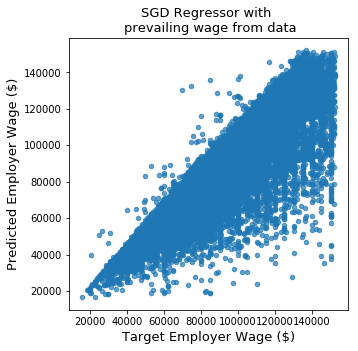

Mean: $80045.446
Standard deviation: $22632.645
Pearson coefficient: 0.876


In [241]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_real, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('SGD Regressor with \n prevailing wage from data', size=13)
plt.show()

print("Mean: $%.3f" %np.mean(y_pred_wage_real))
print("Standard deviation: $%.3f" %np.std(y_pred_wage_real))
print("Pearson coefficient: %.3f" %np.corrcoef(em_y_test_real, y_pred_wage_real)[0,1])

The mean absolute error appears good as compared to the errors encountered while developing model 1, however the plot of the predicted values against the target values shows that most of the salaries tend to be understimated and the appearance of an upper linear boundary.

## Step 2: Predict employer wage using predicted prevailing wage from model 1

Let's add the logarithm of the prevailing wage predictions to the training set.

In [242]:
em_X_train['pw_pred_log'] = np.log(model_1_log(em_X_train))
em_X_train.head()

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

,job_title,occupational_name,prevailing_wage,city,county,state,postal_code,pw_log,job_title_enc,occupational_name_enc,city_enc,county_enc,state_enc,postal_code_enc,pw_pred_log
370405,CIVIL ENGINEER (ENERGY),CIVIL ENGINEERS,73715.0,SOUTH SAN FRANCISCO,SAN MATEO,CA,94080,11.207962,-1.0,619.0,4940.0,2288.0,55,8776.0,11.277279
512622,SENIOR ADVERTISING ANALYST,COMPUTER SYSTEMS ANALYSTS,116522.0,SAN JOSE,SANTA CLARA,CA,95125,11.665835,-1.0,641.0,5068.0,2306.0,55,8548.0,11.547268
485279,VISITING ASSISTANT PROFESSOR,"ECONOMICS TEACHERS, POSTSECONDARY",37790.0,BATON ROUGE,EAST BATON ROUGE,LA,70803,10.539800,36538.0,545.0,4831.0,2130.0,21,7749.0,10.766315
95803,SYSTEMS ANALYST,COMPUTER SYSTEMS ANALYSTS,60320.0,LANSING,EATON,MI,48913,11.007419,37036.0,641.0,4865.0,1998.0,45,4388.0,10.930430
297904,PROGRAMMER ANALYST,"SOFTWARE DEVELOPERS, APPLICATIONS",73590.0,HAMILTON,MERCER,NJ,08619,11.206264,37039.0,642.0,4667.0,2275.0,52,8171.0,11.243992


Features used to develop model for employer wage prediction:

In [243]:
features2 = ['state', 'postal_code', 'pw_pred_log']

In [244]:
# Set parameters for batch training
batch_size = 20000
# Create regressor
regressor2 = SGDRegressor(max_iter=600, random_state=seed)
# Get batches
train_batches = batches(batch_size, em_X_train[features2], em_y_train)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    # Transform batch to one-hot encoding
    X_batch_trans = encoder.transform(X_batch)
    # Partial fit
    regressor2.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor2.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 259.332s


In [245]:
# Predict prevailing wage on test set
em_X_test['pw_pred_log'] = predict_pw_log(em_X_test)
# Predict on test set using features2
test_batches = batches(batch_size, em_X_test[features2], em_y_test)
y_pred_wage_2 = []
for X_batch, y_batch in test_batches:
    X_test_trans = encoder.transform(X_batch)
    y_pred_wage_2.extend(regressor2.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error_log_2 = mean_absolute_error(em_y_test, y_pred_wage_2)
print("Step 2 - SGDRegressor:")
print("\t Mean absolute error in natural log values: %.3f" % mean_error_log_2)
# Values in dollars
y_pred_wage_real_2 = np.exp(y_pred_wage_2)
mean_error_real_2 = mean_absolute_error(em_y_test_real, y_pred_wage_real_2)
print("\t Mean absolute error: $%.3f" % mean_error_real_2)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Step 2 - SGDRegressor:
	 Mean absolute error in natural log values: 0.158
	 Mean absolute error: $12899.300


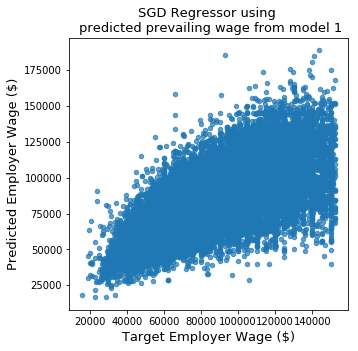

Mean: $81444.138
Standard deviation: $19461.044
Pearson coefficient: 0.700


In [246]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_real_2, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('SGD Regressor using \n predicted prevailing wage from model 1', size=13)
plt.show()

print("Mean: $%.3f" %np.mean(y_pred_wage_real_2))
print("Standard deviation: $%.3f" %np.std(y_pred_wage_real_2))
print("Pearson coefficient: %.3f" %np.corrcoef(em_y_test_real, y_pred_wage_real_2)[0,1])

As expected the error is higher than the model from step 1, however by comparing the plots of step 1 and 2, we see that the linear upper boundary dissapeared and that more points are overestimated. This model also tends to compress the points around the mean.

## Step 3: Predict employer wage using only postal_code and state

In [247]:
features3 = ['state', 'postal_code']

In [248]:
# Set parameters for batch training
batch_size = 20000
# Create regressor
regressor3 = SGDRegressor(max_iter=600, random_state=seed)
# Get batches
train_batches = batches(batch_size, em_X_train[features3], em_y_train)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    # Transform batch to one-hot encoding
    X_batch_trans = encoder.transform(X_batch)
    # Partial fit
    regressor3.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor3.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 254.658s


In [249]:
# Predict on test set using features3
test_batches = batches(batch_size, em_X_test[features3], em_y_test)
y_pred_wage_3 = []
for X_batch, y_batch in test_batches:
    X_test_trans = encoder.transform(X_batch)
    y_pred_wage_3.extend(regressor3.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error_log_3 = mean_absolute_error(em_y_test, y_pred_wage_3)
print("Step 3 - SGDRegressor:")
print("\t Mean absolute error in natural log values: %.3f" % mean_error_log_3)
# Values in dollars
y_pred_wage_real_3 = np.exp(y_pred_wage_3)
mean_error_real_3 = mean_absolute_error(em_y_test_real, y_pred_wage_real_3)
print("\t Mean absolute error: $%.3f" % mean_error_real_3)

Step 3 - SGDRegressor:
	 Mean absolute error in natural log values: 0.218
	 Mean absolute error: $17589.771


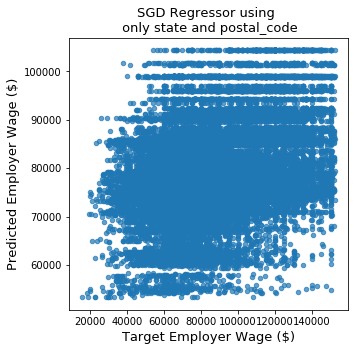

Mean: $78246.179
Standard deviation: $8179.909
Pearson coefficient: 0.352


In [250]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_real_3, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('SGD Regressor using \n only state and postal_code', size=13)
plt.show()

print("Mean: $%.3f" %np.mean(y_pred_wage_real_3))
print("Standard deviation: $%.3f" %np.std(y_pred_wage_real_3))
print("Pearson coefficient: %.3f" %np.corrcoef(em_y_test_real, y_pred_wage_real_3)[0,1])

The error found in this step more than doubles the error from step 1, which is the reference model, and is around 36.4% higher than the error from step 2. Points are further compressed around the mean which is lower than the previous two models from step 1 and 2, showing that salaries are highly underestimated. Also the low Pearson coefficient shows that this model doesn't captures properly the variance of the data and confirms that prevailing wage is a necessary variable to predict employer wage under the conditions of using only state and postal_code as variables.

##  Step 4: predict employer wage as in model 1 without considering prevailing wage

** a. Using a Huber regressor:**

As for model 1, a column merging the strings from the other columns is created.

In [251]:
em_X_train['merged'] = em_X_train.job_title + " " + em_X_train.occupational_name + " " \
                        + em_X_train.city + " " + em_X_train.county + " " + em_X_train.state \
                        + " " + em_X_train.postal_code
em_X_test['merged'] = em_X_test.job_title + " " + em_X_test.occupational_name + " " \
                        + em_X_test.city + " " + em_X_test.county + " " + em_X_test.state \
                        + " " + em_X_test.postal_code

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [252]:
# Define pipeline
steps4 = [('vect4', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('hubr4', HuberRegressor(alpha=0.1, epsilon=1, max_iter=700))]
pipeline4 = Pipeline(steps4)
# Train
start = time()
pipeline4.fit(em_X_train.merged, em_y_train)
end = time()
print("Huber Regressor training time: %.3fs" %(end-start))

Huber Regressor training time: 23.756s


In [253]:
# Prediction by the model
y_pred_wage_4 = pipeline4.predict(em_X_test.merged)
# Error on natural log data
pipeline4_error = mean_absolute_error(em_y_test, y_pred_wage_4)
print("Step 4: Huber Regressor:")
print("\t Mean absolute error in natural log values: %.3f" %pipeline4_error)
# Error on real data
y_pred_wage_4_real = np.exp(y_pred_wage_4)
pipeline4_error_real = mean_absolute_error(em_y_test_real, y_pred_wage_4_real)
print("\t Mean absolute error in dollars: $%.3f" %pipeline4_error_real)

Step 4: Huber Regressor:
	 Mean absolute error in natural log values: 0.145
	 Mean absolute error in dollars: $11950.345


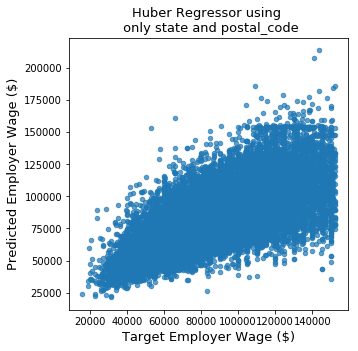

Mean: $79650.732
Standard deviation: $19484.331
Pearson coefficient: 0.728


In [287]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_4_real, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('Huber Regressor using \n only state and postal_code', size=13)
plt.show()

print("Mean: $%.3f" %np.mean(y_pred_wage_4_real))
print("Standard deviation: $%.3f" %np.std(y_pred_wage_4_real))
print("Pearson coefficient: %.3f" %np.corrcoef(em_y_test_real, y_pred_wage_4_real)[0,1])

Using text information to predict employer wage has a better performance than using only state, postal_code and prevailing wage to predict final salaries but still continues to understimate most of the salaries.

As before, let's take a look to a random forest model to gain more insight on the appropiate model to use.

** b. Using a random forest: **

Given that in this step the training and test sets are different from the ones used in model 1, it is necessary to remap the codes for the numerical variables.

In [256]:
# Dictionary containing mapping codes for each feature
coding_dic2 = {}
for column in pr_X.columns:
    # Counting values 
    map_counts = em_X_train[column].value_counts()
    # Assign maximum value to most common label
    coding_dic2[column] = dict(zip(map_counts.index, np.arange(map_counts.shape[0] - 1, -1, -1)))

In [230]:
# Function adding encoded columns to data set
def encode_feats_2(df, coding_dic):
    feats_encoded = []
    for feat in coding_dic.keys():
        feat_dict = coding_dic[feat]
        df[feat+'_enc_2'] = df[feat].map(feat_dict)
        feats_encoded.append(feat+'_enc_2')
    return feats_encoded

We add the encoded columns to the data frame for each categorical feature.

In [260]:
# Apply encode_feats to training data
feats_enc_2 = encode_feats_2(em_X_train, coding_dic2)
# Add predicted prevailing wage to features
feats_enc_2.append('pw_pred_log')
em_X_train.head()

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_title,occupational_name,prevailing_wage,city,county,state,postal_code,pw_log,job_title_enc,occupational_name_enc,...,state_enc,postal_code_enc,pw_pred_log,merged,job_title_enc_2,occupational_name_enc_2,city_enc_2,county_enc_2,state_enc_2,postal_code_enc_2
370405,CIVIL ENGINEER (ENERGY),CIVIL ENGINEERS,73715.0,SOUTH SAN FRANCISCO,SAN MATEO,CA,94080,11.207962,-1.0,619.0,...,55,8776.0,11.277279,CIVIL ENGINEER (ENERGY) CIVIL ENGINEERS SOUTH ...,33320,603,4890,2301,55,8810
512622,SENIOR ADVERTISING ANALYST,COMPUTER SYSTEMS ANALYSTS,116522.0,SAN JOSE,SANTA CLARA,CA,95125,11.665835,-1.0,641.0,...,55,8548.0,11.547268,SENIOR ADVERTISING ANALYST COMPUTER SYSTEMS AN...,2898,624,5023,2319,55,8558
485279,VISITING ASSISTANT PROFESSOR,"ECONOMICS TEACHERS, POSTSECONDARY",37790.0,BATON ROUGE,EAST BATON ROUGE,LA,70803,10.539800,36538.0,545.0,...,21,7749.0,10.766315,VISITING ASSISTANT PROFESSOR ECONOMICS TEACHER...,36835,519,4791,2145,21,7764
95803,SYSTEMS ANALYST,COMPUTER SYSTEMS ANALYSTS,60320.0,LANSING,EATON,MI,48913,11.007419,37036.0,641.0,...,45,4388.0,10.930430,SYSTEMS ANALYST COMPUTER SYSTEMS ANALYSTS LANS...,37242,624,4787,2008,45,6556
297904,PROGRAMMER ANALYST,"SOFTWARE DEVELOPERS, APPLICATIONS",73590.0,HAMILTON,MERCER,NJ,08619,11.206264,37039.0,642.0,...,52,8171.0,11.243992,"PROGRAMMER ANALYST SOFTWARE DEVELOPERS, APPLIC...",37245,625,4628,2286,52,8095


Only the columns containing the encoding information plus the predicted prevailing wage are used to train the random forest regressor.

In [278]:
forest2 = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=20)
start = time()
forest2.fit(em_X_train[feats_enc_2], em_y_train)
end = time()

print("Random Forest training time: %.3fs" %(end-start))

Random Forest training time: 14.269s


In [279]:
# Apply encode_feats to test data
_ = encode_feats_2(em_X_test, coding_dic2)
em_X_test.fillna(-1, inplace=True)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [280]:
# Prediction by the model
em_pred_forest = forest2.predict(em_X_test[feats_enc_2])
# Error on natural log data
em_forest_error = mean_absolute_error(em_y_test, em_pred_forest)
print("Random Forest:")
print("\t Mean absolute error in natural log values: %.3f" %em_forest_error)
# Error on real data
em_pred_forest_real = np.exp(em_pred_forest)
em_forest_error_real = mean_absolute_error(em_y_test_real, em_pred_forest_real)
print("\t Mean absolute error in dollars: $%.3f" %em_forest_error_real)

Random Forest:
	 Mean absolute error in natural log values: 0.149
	 Mean absolute error in dollars: $12201.345


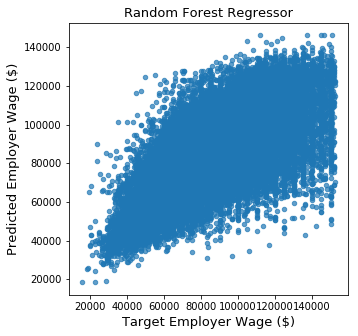

Mean: $80245.505
Standard deviation: $18466.267
Pearson coefficient: 0.717


In [291]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, em_pred_forest_real, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('Random Forest Regressor', size=13)
plt.show()

print("Mean: $%.3f" %np.mean(em_pred_forest_real))
print("Standard deviation: $%.3f" %np.std(em_pred_forest_real))
print("Pearson coefficient: %.3f" %np.corrcoef(em_y_test_real, em_pred_forest_real)[0,1])

**Random forest without prevailing wage:**

In [282]:
forest2b = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=20)
start = time()
forest2b.fit(em_X_train[feats_enc_2[:-1]], em_y_train)
end = time()

print("Random Forest training time: %.3fs" %(end-start))

Random Forest training time: 16.920s


In [283]:
# Prediction by the model
em_pred_forest2b = forest2b.predict(em_X_test[feats_enc_2[:-1]])
# Error on natural log data
em_forest_error2b = mean_absolute_error(em_y_test, em_pred_forest2b)
print("Random Forest:")
print("\t Mean absolute error in natural log values: %.3f" %em_forest_error2b)
# Error on real data
em_pred_forest_real2b = np.exp(em_pred_forest2b)
em_forest_error_real2b = mean_absolute_error(em_y_test_real, em_pred_forest_real2b)
print("\t Mean absolute error in dollars: $%.3f" %em_forest_error_real2b)

Random Forest:
	 Mean absolute error in natural log values: 0.138
	 Mean absolute error in dollars: $11299.363


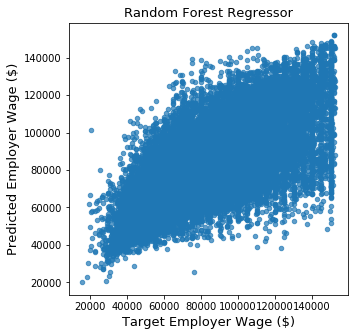

Mean: $80236.667
Standard deviation: $18501.169
Pearson coefficient: 0.731


In [290]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, em_pred_forest_real2b, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('Random Forest Regressor', size=13)
plt.show()

print("Mean: $%.3f" %np.mean(em_pred_forest_real2b))
print("Standard deviation: $%.3f" %np.std(em_pred_forest_real2b))
print("Pearson coefficient: %.3f" %np.corrcoef(em_y_test_real, em_pred_forest_real2b)[0,1])

## Summary

|   | Benchmark model (PR wage from data) | SDGRegressor with predicted PR wage | Huber Regressor on text only | Random Forest without PR wage | Random Forest with PR wage |
|---|---|---|---|---|
|mean absolute error| \$7,936.559 | \$12,899.300 | \$11,950.345 | \$11,299.363 | \$12,201.345 |
| mean | \$8,0045.446 | \$81,444.138 | \$79,650.732 | \$80,236.667 | \$80,245.505 |
| sdt_dev | \$22,632.645 | \$19,461.044 | \$19,484.331 | \$18,501.169 | \$18,466.267 |
| Pearson coefficient | 0.876 | 0.700 | 0.728 | 0.731 | 0.717 |


From the table above, the best two models to predict employer's wage are the huber regressor and the the random forest model that don't take into account prevailing wage predicted by model 1. As we pointed before, the benchmark model cannot be considered because it contains the prevailing wage from the data and that's information that a user of the resulting model will not know. 

Let's explore what is the situation if we average the Huber regressor and the random forest model without prevailing wage. 

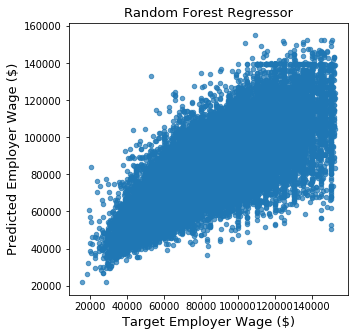

Combined model mean absolute error in dollars: $10862.460
Mean: $79943.700
Standard deviation: $17888.337
Pearson coefficient: 0.775


In [293]:
# Average Huber and random forest regressors
em_model_comb = (y_pred_wage_4_real + em_pred_forest_real2b) / 2

plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, em_model_comb, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('Random Forest Regressor', size=13)
plt.show()

em_model_comb_error = mean_absolute_error(em_y_test_real, em_model_comb)
print("Combined model mean absolute error in dollars: $%.3f" %em_model_comb_error)
print("Mean: $%.3f" %np.mean(em_model_comb))
print("Standard deviation: $%.3f" %np.std(em_model_comb))
print("Pearson coefficient: %.3f" %np.corrcoef(em_y_test_real, em_model_comb)[0,1])

The result above shows that the simple average of the two best models results in a better prediction by considering the mean absolute error and the Pearson coefficient between the predicted and target values.

We conclude that the initial assumption of predicting prevailing wage to then help predict employer wage was not accurate because the predicted prevailing wage carries and error that is then transfered to the final salary predictions. Then, for the final model is necessary to consider all the features but prevailing wage. As well the final model will be the combination of a Huber and random forest regressors. 

-------------------------------

# Final model

The advantage of deducting the final model from the previous conclusions is that now all the training data can be used. This aspect introduces more information to the final that is expected to increase also the reliability on the final regressor.

** Huber Regressor: **

In [327]:
# Merging columns per row
X_train['merged'] = X_train.job_title + " " + X_train.occupational_name + " " + X_train.city \
                    + " " + X_train.county + " " + X_train.state + " " + X_train.postal_code
# Targets to natural log
y_train_log = np.log(y_train)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [328]:
# Define pipeline
final_steps = [('vect4', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('hubr4', HuberRegressor(alpha=0.1, epsilon=1, max_iter=700))]
Huber_pipeline = Pipeline(final_steps)
# Train
start = time()
Huber_pipeline.fit(X_train.merged, y_train_log)
end = time()
print("Huber Regressor training time: %.3fs" %(end-start))

Huber Regressor training time: 89.758s


In [329]:
# Testing on validation set
X_val['merged'] = X_val.job_title + " " + X_val.occupational_name + " " \
                        + X_val.city + " " + X_val.county + " " + X_val.state \
                        + " " + X_val.postal_code
# Predict values from Huber model
y_pred_hub_log = Huber_pipeline.predict(X_val.merged)
# Error on natural log data
y_val_log = np.log(y_val)
Hub_error_log = mean_absolute_error(y_val_log, y_pred_hub_log)
print("Huber Regressor with TF-IDF vectorizer:")
print("\t Mean absolute error in log values: %.3f" %Hub_error_log)
# Error on real data
y_pred_hub = np.exp(y_pred_hub_log)
Hub_error_real2b = mean_absolute_error(y_val, y_pred_hub)
print("\t Mean absolute error in dollars: $%.3f" %Hub_error_real2b)
print("\nOn predictions:")
print("\t Mean: $%.3f" %np.mean(y_pred_hub))
print("\t Standard deviation: $%.3f" %np.std(y_pred_hub))
print("\t Pearson coefficient: %.3f" %np.corrcoef(y_val, y_pred_hub)[0,1])

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Huber Regressor with TF-IDF vectorizer:
	 Mean absolute error in log values: 0.141
	 Mean absolute error in dollars: $11641.588

On predictions:
	 Mean: $79557.443
	 Standard deviation: $19387.983
	 Pearson coefficient: 0.742


**Random Forest**

In [330]:
# Dictionary containing mapping codes for each feature
variables = ['job_title', 'occupational_name', 'city', 'county', 'state', 'postal_code']
model_coding = {}
for column in variables:
    # Counting values 
    map_counts = X_train[column].value_counts()
    # Assign maximum value to most common label
    model_coding[column] = dict(zip(map_counts.index, np.arange(map_counts.shape[0] - 1, -1, -1)))
# Creating encoded columns
RF_feats = encode_feats(X_train, model_coding)
X_train.head(1)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_title,occupational_name,prevailing_wage,city,county,state,postal_code,merged,job_title_enc,occupational_name_enc,city_enc,county_enc,state_enc,postal_code_enc
502579,SENIOR CONSULTANT,FINANCIAL ANALYSTS,95077.0,PALO ALTO,SANTA CLARA,CA,94304,SENIOR CONSULTANT FINANCIAL ANALYSTS PALO ALTO...,72403,787,7076,3269,56,11506


In [331]:
RF_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=20)
start = time()
RF_model.fit(X_train[RF_feats], y_train_log)
end = time()

print("Random Forest training time: %.3fs" %(end-start))

Random Forest training time: 50.372s


In [332]:
# Apply encode_feats to validation data
_ = encode_feats(X_val, model_coding)
X_val.fillna(-1, inplace=True)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [336]:
# Prediction by the model
y_pred_rf_log = RF_model.predict(X_val[RF_feats])
# Error on natural log data
RF_error_log = mean_absolute_error(y_val_log, y_pred_rf_log)
print("Random Forest:")
print("\t Mean absolute error in log values: %.3f" %RF_error_log)
# Error on real data
y_pred_rf = np.exp(y_pred_rf_log)
RF_error = mean_absolute_error(y_val, y_pred_rf)
print("\t Mean absolute error in dollars: $%.3f" %RF_error)
print("\nOn predictions:")
print("\t Mean: $%.3f" %np.mean(y_pred_rf))
print("\t Standard deviation: $%.3f" %np.std(y_pred_rf))
print("\t Pearson coefficient: %.3f" %np.corrcoef(y_val, y_pred_rf)[0,1])

Random Forest:
	 Mean absolute error in log values: 0.123
	 Mean absolute error in dollars: $10127.185

On predictions:
	 Mean: $80389.487
	 Standard deviation: $19317.992
	 Pearson coefficient: 0.778


**Combining Huber Regressor and Random Forest Regressor**

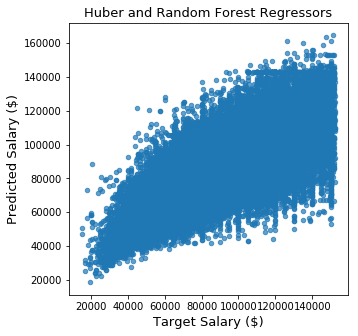

Combined model: average between random forest and Huber regressors:
	 Mean absolute error: $10173.014

On predictions:
	 Mean: $79973.465
	 Standard deviation: $18334.418
	 Pearson coefficient: 0.802


In [335]:
y_pred_combo = (y_pred_hub + y_pred_rf) / 2

plt.figure(figsize=(5,5))
plt.scatter(y_val, y_pred_combo, alpha=0.7, s=20)
plt.xlabel('Target Salary ($)', size=13)
plt.ylabel('Predicted Salary ($)', size=13)
plt.title('Huber and Random Forest Regressors', size=13)
plt.show()

combo_error = mean_absolute_error(y_val, y_pred_combo)
print("Combined model: average between random forest and Huber regressors:")
print("\t Mean absolute error: $%.3f" %combo_error)
print("\nOn predictions:")
print("\t Mean: $%.3f" %np.mean(y_pred_combo))
print("\t Standard deviation: $%.3f" %np.std(y_pred_combo))
print("\t Pearson coefficient: %.3f" %np.corrcoef(y_val, y_pred_combo)[0,1])

In [339]:
from sklearn.metrics import mean_squared_log_error

Hub_mean_square_log_error = mean_squared_log_error(y_val, y_pred_hub)
RF_mean_square_log_error = mean_squared_log_error(y_val, y_pred_rf)
combo_mean_square_log_error = mean_squared_log_error(y_val, y_pred_combo)

print("Mean square errors:")
print("\t Huber regressor: %.3f" %Hub_mean_square_log_error)
print("\t Random Forest regressor: %.3f" %RF_mean_square_log_error)
print("\t Cmmbined regressor: %.3f" %combo_mean_square_log_error)

Mean square errors:
	 Huber regressor: 0.036
	 Random Forest regressor: 0.032
	 Cmmbined regressor: 0.029


|   | Huber Regressor | Random Forest Regressor | Average Model|
|---|---|---|---|
| mean | \$79,557.443 | \$80,389.487 | \$79,973.465 |
| sdt_dev | \$19,387.983 | \$19,317.992 | \$18,334.418 |
| Pearson coefficient | 0.742 | 0.778 | 0.802 |
|mean absolute error | \$11,641.588 | \$10,127.185 | \$10,173.014 |
|mean squared log error | 0.036 | 0.032 | 0.029 |

In [402]:
print("On targets:")
print("\t Mean: $%.3f" %np.mean(y_val))
print("\t Standard deviation: $%.3f" %np.std(y_val))

On targets:
	 Mean: $81477.045
	 Standard deviation: $24067.398


--------------------------------------